# Learning Model Segment 3

#### Looks at different types of supervised and deep learning models:
  * Logistic Regression    
  * Support Vector Machine
  * Deep Learning Model
  * Random Forest Model

In [1]:
# Choose type of model to run:
#     LR = logistic regression, NN = neural net, SV = support vector machine, RF = Random Forest Classifier

model_type = 'NN' 

In [2]:
def select_model(mtype):
    if mtype == 'LR':
        return 'U'
    elif mtype == 'NN':
        return 'S'
    elif mtype == 'SV':
        return 'S'
    elif mtype == 'RF':
        return 'S'
dataset = select_model(model_type)
print(model_type, dataset)

NN S


In [3]:
# Import dependancies
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import create_engine
import psycopg2
import config as creds
import re
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import data from csv file

In [4]:
# input merged dataset and select the appropriate dataframe
df=pd.read_csv("Resources/merged_movies.csv", low_memory=False)

# drop genre variables from TMDB 
df.drop(['g_Action_TM', 'g_Adventure_TM', 'g_Animation_TM', 'g_Comedy_TM', 'g_Crime_TM', 
       'g_Documentary_TM', 'g_Drama_TM', 'g_Family_TM', 'g_Fantasy_TM', 'g_History_TM', 'g_Horror_TM',
       'g_Music_TM', 'g_Mystery_TM', 'g_News', 'g_Reality_TV', 'g_Romance_TM',
       'g_Sci_Fi', 'g_Sport', 'g_Thriller_TM','g_War_TM', 'g_Western_TM'], axis=1, inplace=True)

# drop columns with high percentage of missing values, and not needed
df.drop(["budget_IM", "budget_TM", "collection", "g_Foreign", "genre_name", "metascore", "orig_lang_cd", 
              "original_language", "popularity", "release_year_TM", "revenue", "runtime", "usa_gross_income", 
              "website", "worlwide_gross_income", "year"], axis=1, inplace=True)

# drop columns with too many unique values 
df.drop(["_merge", "director_list", "country", "genre_list", "imdb_id", "language", "title"], axis=1, inplace=True)

# Drop any rows with missing values. Reassess whether the nulls can/should be recoded and kept.
df.dropna(axis=0, how="any", inplace=True)

# Choose dependent = predicted value:
# Options: avg_vote, reviews_from_critics, reviews_from_users, votes
# For this model pass, use avg_vote >= 7 as success
df["success"] = df["avg_vote"].map(lambda x: 1 if x>= 7.0 else 0)

# Drop unneeded dependent variables
df.drop(["avg_vote", "reviews_from_users", "reviews_from_critics", "votes"], axis=1, inplace=True)

# Categorical variables for encoding, if needed
cat_vars = ['g_Action_IM', 'g_Adult', 'g_Adventure_IM',
       'g_Animation_IM', 'g_Biography', 'g_Comedy_IM', 'g_Crime_IM',
       'g_Documentary_IM', 'g_Drama_IM', 'g_Family_IM', 'g_Fantasy_IM',
       'g_History_IM', 'g_Horror_IM', 'g_Music_IM', 'g_Musical',
       'g_Mystery_IM', 'g_Romance_IM', 'g_Thriller_IM', 'g_War_IM',
       'g_Western_IM']

print(df.columns)

Index(['duration', 'g_Action_IM', 'g_Adult', 'g_Adventure_IM',
       'g_Animation_IM', 'g_Biography', 'g_Comedy_IM', 'g_Crime_IM',
       'g_Documentary_IM', 'g_Drama_IM', 'g_Family_IM', 'g_Fantasy_IM',
       'g_History_IM', 'g_Horror_IM', 'g_Music_IM', 'g_Musical',
       'g_Mystery_IM', 'g_Romance_IM', 'g_Thriller_IM', 'g_War_IM',
       'g_Western_IM', 'release_year_IM', 'success'],
      dtype='object')


## Pre-process

In [5]:
if dataset == 'S':  # create encoded and scaled dataset
    # Encode categorical variables
    # Create a OneHotEncoder instance
    enc = OneHotEncoder(sparse=False)
    # Fit and transform the OneHotEncoder using the categorical variable list
    encode_df =pd.DataFrame(enc.fit_transform(df[cat_vars]))
    # Add the encoded variable names to the DataFrame
    encode_df.columns =enc.get_feature_names(cat_vars)
    # Merge one-hot encoded features and drop the originals
    df =df.merge(encode_df,left_index=True,right_index=True)
    df.drop(cat_vars,axis=1, inplace=True)

## Create Sample Datasets

In [6]:
# Split our preprocessed data into our features and target arrays
y =df["success"]
# y =df["success"].values
X =df.drop(["success"],1)
# X =df.drop(["success"],1).values

# Split the preprocessed data into a training and testing dataset
X_train,X_test,y_train,y_test =train_test_split(X,y,stratify=y,random_state=78)

## Scale data if needed

In [7]:
if dataset == 'S':  # create encoded and scaled dataset
    X_scaler = StandardScaler()
    # Fit the scaler
    X_scaler.fit(X_train)
    # Scale the data
    X_train =X_scaler.transform(X_train)
    X_test =X_scaler.transform(X_test)

## Define the learning model

In [8]:
if model_type == "RF":
    rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 
    rf_model = rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    acc_score = accuracy_score(y_test, predictions)
    
    print("Confusion Matrix")
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    # Calculate feature importance in the Random Forest model.
    importances = rf_model.feature_importances_
    output=sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
    output_df = pd.DataFrame(output, columns = ['importance','feature'])
    print(output_df)

In [9]:
if model_type == "LR":
    log_classifier =LogisticRegression(solver="lbfgs",max_iter=200)
    print(type(X_train))
    print(type(y_train))
    
    # Train the model
    log_classifier.fit(X_train,y_train)

    # Evaluate the model
    y_pred =log_classifier.predict(X_test)
    print(f" Logistic regression model accuracy: {accuracy_score(y_test,y_pred):.3f}")

In [10]:
if model_type == "SV":
    # Create the SVM model
    svm =SVC(kernel='linear')
    print('created svm')
    
    # Train the model
    svm.fit(X_train,y_train)
    print('fit svm')
    
    # Evaluate the model
    y_pred =svm.predict(X_test)
    print('predicted svm')
    print(f" SVM model accuracy: {accuracy_score(y_test,y_pred):.3f}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 215       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 237
Trainable params: 237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
754/754 [==============================] - 1s 725us/step - loss: 0.5042 - accuracy: 0.7839 - val_loss: 0.4262 - val_accuracy: 0.8286
Epoch 2/30
754/754 [==============================] - 0s 565us/step - loss: 0.4283 - accuracy: 0.8252 - val_loss: 0.4202 - val_accuracy: 0.8266
Epoch 3/30
754/754 [==============================] - 0s 579us/step - loss: 0.4245 - accuracy: 0.824

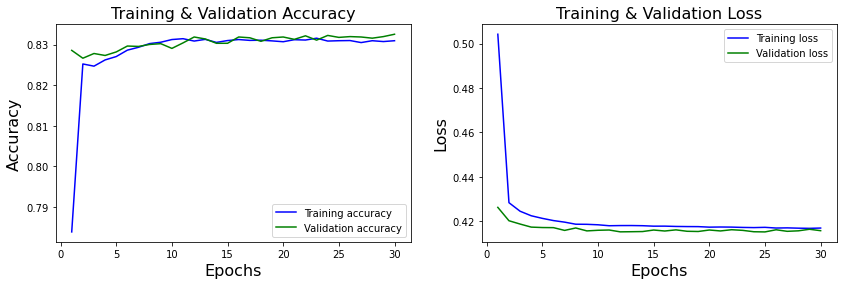

In [11]:
if model_type == "NN":
    # Create the Keras Sequential model
    # use validation_split argument to set the proportion of the dataset to reserve for validation
    number_input_features =len(X_train[0])
    hidden_nodes_layer1 = 5
    hidden_nodes_layer2 = 3
    nn =tf.keras.models.Sequential()
    # layers
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,activation="tanh",input_dim=number_input_features))
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation="tanh"))

    # Add the output layer that uses a probability activation function
    nn.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    
    # Check the structure of the Sequential model
    nn.summary()

    # Compile the Sequential model together and customize metrics
    nn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

    # Fit the model to the training data
    fit_model =nn.fit(X_train,y_train,validation_split=.3, epochs=30)

    # Evaluate the model using the test data
    model_loss,model_accuracy =nn.evaluate(X_test,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
    
    # Create learning curve for both train and validation datasets to evaluate under- and over-fitting

    history_dict=fit_model.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    #
    # Plot the model accuracy vs Epochs
    #
    ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
    ax[0].plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    ax[0].set_title('Training & Validation Accuracy', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Accuracy', fontsize=16)
    ax[0].legend()
    #
    # Plot the loss vs Epochs
    #
    ax[1].plot(epochs, loss_values, 'b', label='Training loss')
    ax[1].plot(epochs, val_loss_values, 'g', label='Validation loss')
    ax[1].set_title('Training & Validation Loss', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Loss', fontsize=16)
    ax[1].legend()

    plt.show()